In [56]:
#This project is made as a part of Data Science course, recommender systems block
#In particular this work covers collaborative filtering recommender system
#The goal of this project is to build a model and evaluate its effectiveness 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
#Open the files
df_raiting = pd.read_csv("ratings.csv")
df_movies = pd.read_csv("movies.csv")

In [3]:
df_raiting.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df_raiting.describe()
#No missing values in the dataset

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [6]:
#Merging two datasets
df_total = df_raiting.merge(df_movies[["movieId","title"]],how = "left", on="movieId").drop(columns="timestamp",axis=0)

In [7]:
df_total.groupby("rating").count()

,userId,movieId,title
rating,,,
0.5,1370,1370,1370
1.0,2811,2811,2811
1.5,1791,1791,1791
2.0,7551,7551,7551
2.5,5550,5550,5550
3.0,20047,20047,20047
3.5,13136,13136,13136
4.0,26818,26818,26818
4.5,8551,8551,8551


C:\Users\acer\AppData\Local\Temp\ipykernel_14932\2185879960.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


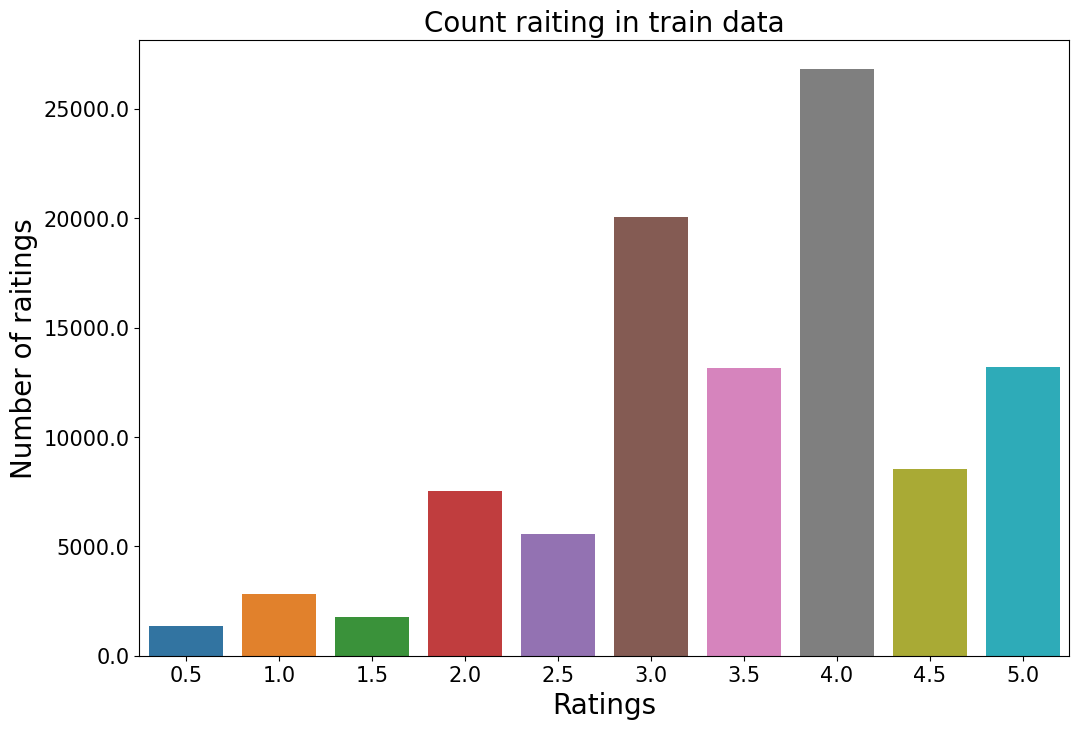

In [8]:
plt.figure(figsize = (12,8))
ax = sns.countplot(x = "rating", data = df_total)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count raiting in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of raitings", fontsize = 20)
plt.show()

In [ ]:
#long tail plot

In [9]:
df_to_plot = df_total['movieId'].value_counts().reset_index()
df_to_plot.columns = ['movieId', 'count']
df_to_plot['cumulative_volume'] = df_to_plot['count'].cumsum()
df_to_plot['percent_of_total_volume'] = df_to_plot['cumulative_volume']/df_to_plot['count'].sum()

C:\Users\acer\AppData\Local\Temp\ipykernel_14932\4019338645.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])


Text(0.5, 1.0, 'Ratings long tail plot')

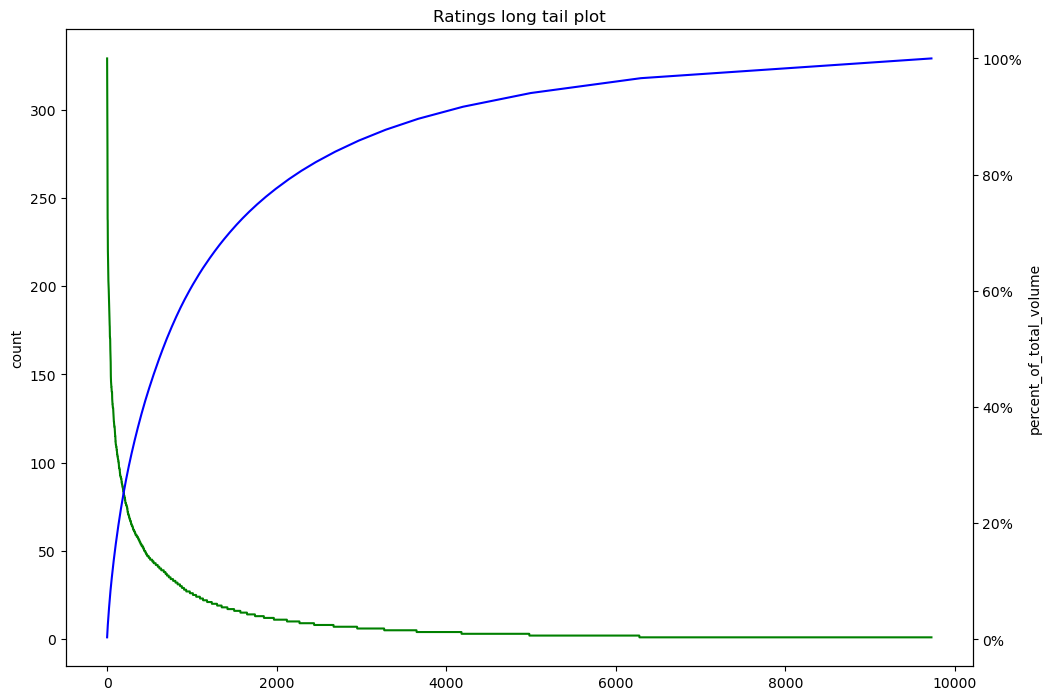

In [10]:
fig, ax2 = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.lineplot(data=df_to_plot['count'], color="g")
ax2 = plt.twinx()
sns.lineplot(data=df_to_plot['percent_of_total_volume'], color="b", ax=ax2)
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])
ax2.set_title('Ratings long tail plot')
#Most ratings are given to a relatively small number of films
#2 thousand films (20% of the total number) account for approximately 80% of the total rating

#For the most popular films, we have more reactions, 
#hence these films are more correlated with others and a 
#model(by similarity with a cosine measure or Pearson correlation) recommends them more often

In [11]:
#Train/Test split
train_data, test_data = train_test_split(df_total, test_size = 0.25, random_state=57)

In [12]:
test_res = test_data.copy().groupby('userId', as_index=False)['title'].agg({'actual': (lambda x: list(set(x)))})
test_res = test_res.set_index("userId")

In [13]:
test_res

,actual
userId,
1,"[Young Sherlock Holmes (1985), Enemy of the St..."
2,"[Shawshank Redemption, The (1994), The Jinx: T..."
3,"[Conan the Barbarian (1982), Patton (1970), Da..."
4,"[This Is Spinal Tap (1984), Mars Attacks! (199..."
5,"[Dead Man Walking (1995), Shawshank Redemption..."
...,...
606,"[Persona (1966), Ghost (1990), Titanic (1997),..."
607,"[Friday the 13th Part 2 (1981), Shawshank Rede..."
608,"[Chicago (2002), Evil Dead, The (1981), Dummy ..."


In [14]:
#Create user-item matrix for train and test.
train_data_ui = train_data.pivot_table(index=['userId'], columns=['title'], values='rating')
test_data_ui = test_data.pivot_table(index=['userId'], columns=['title'], values='rating')

In [15]:
train_data_ui

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...,Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]³ 3 Génesis (2012),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN


In [16]:
#CF recomender model based on Pearson similarity
cf_recs = []
#Creating correlation matrix
corr_matrix = train_data_ui.corr(method='pearson', min_periods=100)

In [17]:
corr_matrix

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...,Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]³ 3 Génesis (2012),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
for i in test_res.index:
    user_ratings = train_data_ui.loc[i].dropna()
    simCandidates = pd.Series()

    for j in range(0, len(user_ratings.index)): # Go through the list of all the films rated by the user
        sims = corr_matrix[user_ratings.index[j]].dropna() # Gets the movies similar to those rated by this user
        sims = sims.map(lambda x: x * user_ratings[j]) # Multiply the correlation by the user's rating for the movie
        simCandidates = simCandidates.append(sims) # Adding index to the list

    simCandidates = simCandidates.groupby(simCandidates.index).sum()# Summarize the films as they are repeated
    simCandidates.sort_values(inplace = True, ascending = False)

    # Select movies that the user has not watched yet
    intersection_set = set.intersection(set(simCandidates.index), set(user_ratings.index))
    not_watched = list(set(simCandidates.index) - set(user_ratings.index))
    colab_predictions = simCandidates[not_watched].sort_values(ascending = False).head(10).index.to_list()#top 10 recomendations 
    cf_recs.append(colab_predictions)

In [20]:
test_res['colab_predictions'] = cf_recs
test_res.head()

,actual,colab_predictions
userId,,
1,"[Young Sherlock Holmes (1985), Enemy of the St...","[Shawshank Redemption, The (1994), Forrest Gum..."
2,"[Shawshank Redemption, The (1994), The Jinx: T...",[]
3,"[Conan the Barbarian (1982), Patton (1970), Da...",[]
4,"[This Is Spinal Tap (1984), Mars Attacks! (199...",[Star Wars: Episode VI - Return of the Jedi (1...
5,"[Dead Man Walking (1995), Shawshank Redemption...","[Silence of the Lambs, The (1991), Forrest Gum..."


In [21]:
#Evluation

#The system will be evaluated by the next metrics:
#Catalog Coverage
#User coverage
#Hitrate@k

In [22]:
#Catalog Coverage
def catalog_coverage(predicted, catalog, k: int) -> float:
    '''
    k: integer
        The number of observed recommendation lists
        which randomly choosed in our offline setup
    '''
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0),3)
    return catalog_coverage

In [23]:
catalog = df_total.title.unique().tolist()
cf_cat_coverage = catalog_coverage(cf_recs, catalog, 100)
print("Catalog coverage (cf): {}".format(cf_cat_coverage))
#As CF recommends popular films it gives a small value of catalog coverage metric

Catalog coverage (cf): 0.001


In [25]:
#User coverage
def user_coverage(predicted) -> float:
    """
    predicted : a list of lists
        Ordered predictions
    Returns
    ----------
    user_coverage:
        Share of test users in predicted list to whom we provided recommendation
        rounded to 2 decimal places
    """
    
    L_predictions = sum([1 if len(i) > 0 else 0 for i in predicted])
    user_coverage = round(L_predictions/(len(predicted)*1.0),2)
    
    return user_coverage


In [26]:
print("User coverage (cf): {}".format(user_coverage(cf_recs)))
#We cannot make recommendations for all users of the test data because 
#the system is lacking sufficient information about these users

User coverage (cf): 0.82


In [27]:
#Hitrate@k

def hitrate_k(predicted, actual, k: int) -> int:
    """
    predicted : a list of lists with recommendations
    actual: list of lists with actual movie watches
    k: integer
        The maximum number of recommendations in a list
    Returns
    ----------
    hitrate_k:
        The average number of correct recommendations for a user
    """
    cor_rec = 0
    
    for i in predicted.index:
        pred = predicted.loc[i][:k]
        ints = len(set.intersection(set(pred), set(actual.loc[i])))
        if ints:
            cor_rec+=ints
   
    hitrate_k = round(cor_rec/len(predicted.index),2)
    return hitrate_k


In [28]:
cf_hitrate_k = hitrate_k(test_res.colab_predictions, test_res.actual, 10)
print("Hitrate_k (cf): {}".format(cf_hitrate_k))
#The system recommends films that are relevant or interesting to the user (in 77% of the causes)

Hitrate_k (cf): 0.77
